In [6]:
import pandas as pd
import numpy as np
from scipy import stats, signal
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, balanced_accuracy_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.cross_decomposition import PLSRegression
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
import tensorflow as tf
from utils import load_data, feature_selection, plot_graphs, preprocessing
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import re
from optuna.samplers import TPESampler, CmaEsSampler
optuna.logging.set_verbosity(0)

In [3]:
import json
with open('data/results_dict.txt', 'r') as f:
    results_dict = json.load(f)

In [15]:
for exp, results in results_dict.items():
    acc = []
    f1 = []
    prec = []
    rec = []
    bacc = []
    prstr('-------------------------------')
    print(exp)
    for result in results:
        acc.append(result['acc'])
        f1.append(result['f1'])
        prec.append(result['precision'])
        rec.append(result['recall'])
        bacc.append(result['b_acc'])
    string_print = ""
    acc_mean, acc_std = round(np.mean(acc), 3), round(np.std(acc), 3)
    f1_mean, f1_std = round(np.mean(f1), 3), round(np.std(f1), 3)
    prec_mean, prec_std = round(np.mean(prec), 3), round(np.std(prec), 3)
    rec_mean, rec_std = round(np.mean(rec), 3), round(np.std(rec), 3)
    bacc_mean, bacc_std = round(np.mean(bacc), 3), round(np.std(bacc), 3)
    str_print = f"""
    {acc_mean} $\pm$ {acc_std}   &  {bacc_mean} $\pm$ {bacc_std}      &  {rec_mean} $\pm$ {rec_std} & {prec_mean} $\pm$ {prec_std} & {f1_mean} $\pm$ {f1_std}
    """
    print(str_print)

    # print('acc: ', round(np.mean(acc), 3), round(np.std(acc), 3))
    # print('bacc: ', round(np.mean(bacc), 3), round(np.std(bacc), 3))
    # print('rec: ', round(np.mean(rec), 3), round(np.std(rec), 3))
    # print('prec: ', round(np.mean(prec), 3), round(np.std(prec), 3))
    # print('f1: ', round(np.mean(f1), 3), round(np.std(f1), 3))

-------------------------------
pad_raw_xgb

    0.74 $\pm$ 0.017   &  0.741 $\pm$ 0.013      &  0.748 $\pm$ 0.027 & 0.649 $\pm$ 0.029 & 0.694 $\pm$ 0.012
    
-------------------------------
pad_raw_catb

    0.771 $\pm$ 0.021   &  0.756 $\pm$ 0.023      &  0.683 $\pm$ 0.045 & 0.724 $\pm$ 0.031 & 0.702 $\pm$ 0.029
    
-------------------------------
pad_raw_lgbm

    0.76 $\pm$ 0.03   &  0.757 $\pm$ 0.025      &  0.743 $\pm$ 0.015 & 0.683 $\pm$ 0.047 & 0.711 $\pm$ 0.026
    
-------------------------------
pad_raw_svm

    0.833 $\pm$ 0.013   &  0.809 $\pm$ 0.015      &  0.693 $\pm$ 0.033 & 0.857 $\pm$ 0.027 & 0.766 $\pm$ 0.021
    
-------------------------------
pad_raw_pslda

    0.743 $\pm$ 0.004   &  0.699 $\pm$ 0.005      &  0.494 $\pm$ 0.011 & 0.773 $\pm$ 0.005 & 0.602 $\pm$ 0.009
    
-------------------------------
pad_raw_cnn

    0.805 $\pm$ 0.017   &  0.794 $\pm$ 0.007      &  0.74 $\pm$ 0.049 & 0.768 $\pm$ 0.054 & 0.75 $\pm$ 0.007
    
-------------------------------
pad

In [3]:
import joblib

gbm_model = joblib.load('data/model_features_lightgbm_fold_4.joblib')

/home/flavioloss/miniconda3/envs/tcc/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
dataset = pd.read_csv('data/IR-Spectroscopy-PAD-UFES-V4-CandNC-ALL.csv', decimal=",")
df_valid = dataset[dataset['Classe'].isin(
    ['ACK', 'CBC', 'SEK', 'CEC', 'NEV', 'MEL']
    )]

X = df_valid.drop(['y'], axis=1)
y = df_valid['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=X['Classe'], 
    test_size=0.1, 
    random_state=42)

In [49]:
def create_features_stats(X, n_subsets):
    """
    Create a Dataframe of features of signal, given a number of subdivisions of the amplitudes
    """
    all_cols = np.array(X.columns)
    splits = np.array_split(all_cols, n_subsets)
    df_features = pd.DataFrame()
    for subset, vals in zip(range(1, n_subsets+1), splits):
        means = []; stds = []; medians = []; kurts = []; skews = []; maxs = []; mins = []
        peaks = []; rms = []; p2p = []; var = []; crest_factor = []
        df_sub = X[vals]

        for idx, row in df_sub.iterrows():
            means.append(np.mean(row.values))
            stds.append(np.std(row.values))
            medians.append(np.median(row.values))
            kurts.append(stats.kurtosis(row.values))
            skews.append(stats.skew(row.values))
            maxs.append(np.max(row.values))
            mins.append(np.min(row.values))
            peaks.append(np.max(np.abs(row.values)))
            rms.append(np.sqrt(np.mean(row.values**2)))
            p2p.append(np.ptp(row.values))
            var.append(np.var(row.values))
            crest_factor.append(np.max(np.abs(row.values))/np.sqrt(np.mean(row.values**2)))
        
        vals = [val.replace(',', '.') for val in vals]

        df_temp = pd.DataFrame({    
                                f"Mean {str(vals[0])} to {str(vals[-1])}": means, 
                                f"Standard Deviation {str(vals[0])} to {str(vals[-1])}": stds,
                                f"Median {str(vals[0])} to {str(vals[-1])}": medians, 
                                f"Kurtosis {str(vals[0])} to {str(vals[-1])}": kurts,
                                f"Skewness {str(vals[0])} to {str(vals[-1])}": skews, 
                                f"Max {str(vals[0])} to {str(vals[-1])}": maxs, 
                                f"Min {str(vals[0])} to {str(vals[-1])}": mins,
                                f"Peaks {str(vals[0])} to {str(vals[-1])}": peaks, 
                                f"RMS {str(vals[0])} to {str(vals[-1])}": rms, 
                                f"Peak to Peak {str(vals[0])} to {str(vals[-1])}": p2p,
                                f"Variance {str(vals[0])} to {str(vals[-1])}": var, 
                                f"Crest Factor {str(vals[0])} to {str(vals[-1])}": crest_factor
                                })
        df_features = pd.concat([df_features, df_temp], axis=1)
    return df_features

X_test_final = X_test.drop(['Classe', 'N', 'Proj', 'Sample'], axis=1).reset_index(drop=True)
X_test_features = create_features_stats(
            X_test_final, n_subsets=26)

In [50]:
exp = shap.TreeExplainer(gbm_model)
shap_values = exp.shap_values(X_test_features)

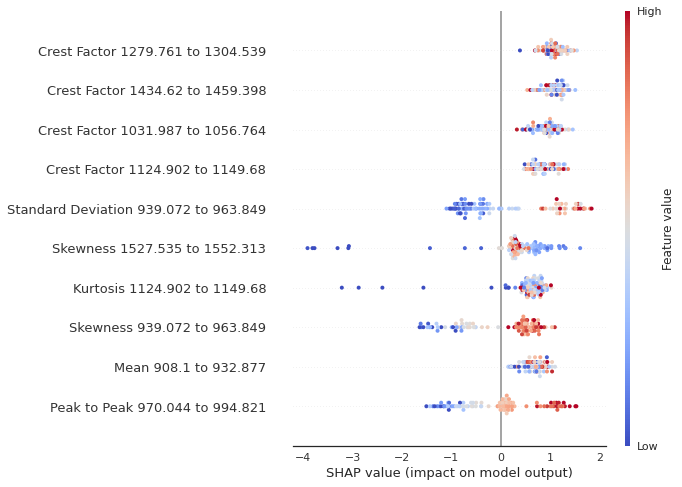

In [51]:
exp = shap.TreeExplainer(gbm_model)
shap_values = exp.shap_values(X_test_features)
shapobj = exp(X_test_features)

sns.set_style("white")
# shap.initjs()
shap.summary_plot(np.take(shapobj.values, 0, axis=-1), 
                  X_test_features, max_display=10,
                  sort=True, show=False, cmap='coolwarm', 
                  plot_size=(7, 8))
# plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

plt.savefig('shap_means.jpg', dpi=300, bbox_inches='tight')

In [64]:
X_deploy = X_test_features.copy()
X_deploy['y_true'] = y_test.reset_index(drop=True)
X_deploy['Classe'] = X_test['Classe'].reset_index(drop=True)
X_deploy['y_pred'] = gbm_model.predict(X_test_features)

In [65]:
valid_classes = ['ACK', 'SEK', 'NEV', 'MEL', 'CBC', 'CEC']

for classe in valid_classes:
    total_classe = 0
    total_cancer = 0
    total_non_cancer = 0
    df_classe = X_deploy[X_deploy['Classe'] == classe]
    for idx, row in df_classe.iterrows():
        # if row['y_true'] == 1:
        total_classe += 1
        if row['y_pred'] == 1:
            total_cancer += 1
        else:
            total_non_cancer +=1
    print(f'{classe}: \n cancer: {total_cancer}/{total_classe} \n non-cancer:  {total_non_cancer}/{total_classe}')

ACK: 
 cancer: 2/34 
 non-cancer:  32/34
SEK: 
 cancer: 0/19 
 non-cancer:  19/19
NEV: 
 cancer: 0/6 
 non-cancer:  6/6
MEL: 
 cancer: 0/1 
 non-cancer:  1/1
CBC: 
 cancer: 24/31 
 non-cancer:  7/31
CEC: 
 cancer: 4/7 
 non-cancer:  3/7
